# Primal-dual method for logistic regression

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pygsp as gsp
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from scipy.optimize import minimize
from datetime import datetime
import os

## The graph dataset

Now let $\mathbf{X} = (\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(N)}) \in \mathbb{R}^{d\times N}$ is the matrix of feature vector with. The learnable parameters $\mathbf{W} = (\mathbf{w}^{(1)}, \ldots, \mathbf{w}^{(N)})
$. The true labels $y = (y^{(1)}, \ldots, y^{(N)})^T$ and the known labels $y_M$ = $\{y^{(i)}\}_{i \in \mathcal{M}}$, for data points in the training set $\mathcal{M}=\{i_{1},\ldots,i_{M}\}$ of size $M$. The regularization parameter $\lambda$ `reg`.

## The logistic network lasso problem

The incidence matrix `D` $\mathbf{D} \in \mathbb{R}^{E\times N}$ 

In [2]:
def incident_matrix(graph):
    v1, v2, weights = graph.get_edge_list()
    a= np.append(weights, -weights)
    b = np.append(v1,  v2)
    c = np.append(np.arange(v1.size), np.arange(v1.size))
    D = sparse.coo_matrix((a, (c, b)), shape=(v1.size, graph.N))
    #D = np.zeros((v1.size, graph.N))
    #D[np.arange(v1.size),v1] = weights
    #D[np.arange(v1.size), v2] = - weights
    return D, weights

The total variation (TV) $ {\rm TV}(\mathbf{W}) = \|\mathbf{W}\|_{\rm TV}$ is the sum of the row norms of the matrix $\mathbf{D} \mathbf{W}^T$

In [3]:
def TV(D):
    return lambda a : np.sum(np.linalg.norm(D.dot(a.T), axis=1))

The empirical loss $ {\rm ERM} = (1/M) \sum_{i\in \mathcal{M}} l(y^{(i)} [\mathbf{w}^{(i)}]^T\mathbf{x}^{(i)})$

In [4]:
def ERM(X, M, y_M):
    return lambda a : (1/np.sum(M)) * np.sum (M* np.log(1 + np.exp(-y_M* np.sum(a*X, axis=0))))

Objective function of the optimization problem ${\rm obj} = {\rm ERM} + \lambda {\rm TV}$

In [5]:
def obj_func(D, X, M, y_M, reg):
    return lambda a : ERM(X, M, y_M)(a) + reg* TV(D)(a)

## Primal Dual Method: 
Vectoring the graph signal to use the primal-dual method $\mathbf{x} = (\mathbf{x}^{(1)T}, \ldots, \mathbf{x}^{(N)T})^T $ is the matrix of feature vector with. $\mathbf{w} = (\mathbf{w}^{(1)T}, \ldots, \mathbf{w}^{(N)T})^T$

Now, let consider the intertible diagonal matrix $\mathbf{T} \in \mathbb{R}^{N \times N}$ and $\mathbf{\Sigma} \in \mathbb{R}^{E \times E}$. Initialize the values for variables

In [6]:
def diag_matrices(graph, D, weights):
    tau = 1/graph.dw
    T = sparse.diags(tau, 0)
    Sigma = sparse.diags(0.9/(2*weights), 0)
    #T =  np.diag(1/graph.dw)
    #Sigma = 0.9*np.diag(1/(2*weights))
    SD = Sigma.dot(D)
    TDT = T.dot(D.T)
    return tau, T, Sigma, SD, TDT

### The primal dual update

In [7]:
def primal_dual(g_params, X, y, M, num_iter=100, reg = 1e-1, print_every=0, inexact_update=True):
    D, tau, T, Sigma, SD, TDT = g_params
    sizeM = np.sum(M)
    y_M = M * y
    obj = obj_func(D, X, M, y_M, reg)
    d, N = X.shape
    E = D.shape[0]
    w = np.zeros((num_iter,d,N))
    u = np.zeros((num_iter, d, E))
    running_average = np.zeros((num_iter,d,N))
    obj_hist = np.zeros(num_iter)
    obj_hist_avg = np.zeros(num_iter)
    obj_hist_avg[0]= obj(running_average[0]) 
    obj_hist[0]= obj(w[0]) 
    non_acc_hist = np.zeros(num_iter)
    acc_hist = np.zeros(num_iter)
    sampling_indices = np.where(M>0)[0]
    for idx in range(1, num_iter):
        w_hat = w[idx-1] - TDT.dot(u[idx-1].T).T
        w[idx] = np.copy(w_hat)
        for i in sampling_indices:
            if inexact_update:
                phi_i = lambda vu : w_hat[:,i] + tau[i] * (y[i] * X[:,i])/(1+np.exp(y[i]*np.sum(vu*X[:,i]) )) /sizeM 
                beta_i = tau[i] * np.power(np.linalg.norm(X[:,i]),2) /sizeM
                lp = int(np.ceil(2 *np.log(idx)/ np.log(1/beta_i)))
                for j in range(lp):
                    w[idx][:,i]= phi_i(w[idx][:,i])
            else:
                equ_18 = lambda vw: np.log(1+ np.exp(-vw @ (y[i] * X[:,i]))) / sizeM + 1/(2 * tau[i]) * np.linalg.norm(vw - w_hat[:,i])**2
                res = minimize(equ_18, w_hat[:,i], method='BFGS')
                w[idx][:,i] = res.x


        u_hat  = u[idx-1] + SD.dot((2*w[idx] - w[idx-1]).T).T
        b = np.linalg.norm(u_hat, axis=0)
        for j in range(b.shape[0]):
            b[j] = (1- reg/b[j]) if b[j]  > reg else 0
        u[idx] = u_hat - b*u_hat
        running_average[idx] = (running_average[idx-1]*(idx-1) + w[idx])/idx
        obj_hist_avg[idx]= obj(running_average[idx])    
        obj_hist[idx]= obj(w[idx])
        non_acc_hist[idx], acc_hist[idx] = accuracy(running_average[idx], X, y, M)
        if print_every !=0 and idx%print_every==0:
            print('loss after %2.0f iteration = %2.5f' % (idx, obj_hist_avg[idx]))
    return w, running_average, obj_hist, obj_hist_avg, non_acc_hist, acc_hist

### Plot the result

In [8]:
def plot_results(X, y, w, obj_hist_avg, reg, prefix ='chain', is_saved=False):
    d, N = X.shape
    num_iter = len(obj_hist_avg)
    x_range = np.arange(1,num_iter)
    f = plt.figure()
    avg_line, = plt.plot(obj_hist_avg[1:], 'r--', label='average weight')
    plt.xlabel('Iteration')
    plt.ylabel('objective value')
    plt.show()
    if is_saved:
        f.savefig('convergence_' +prefix+ '_%1.e.pdf' % reg, bbox_inches='tight')

    f = plt.figure()
    plt.title(r'the recovered weight, $\lambda$ = %1.e' % reg)
    plt.plot(w[num_iter-1,0:].T)
    plt.xlabel('node index')
    plt.show()
    if is_saved:
        f.savefig('weights_' +prefix+ '_%1.e.pdf' % reg, bbox_inches='tight')
    
    f = plt.figure()
    plt.title(r'the recovered labels, $\lambda$ = %1.e' % reg)
    recovered_line, = plt.plot(np.sign(np.sum(w[num_iter-1]*X, axis=0)), 'bs', label='estimated labels')
    true_line, = plt.plot(y, 'r^', label='true labels')
    plt.legend(handles=[recovered_line, true_line])
    plt.xlabel('node index')
    plt.show()
    if is_saved:
        f.savefig('labels_' +prefix+ '_%1.e.pdf' % reg, bbox_inches='tight')


In [9]:
def plot_convergence(obj_hist_avg, reg, prob, prefix ='chain', is_saved=False):
    num_iter = len(obj_hist_avg)
    x_range = np.arange(0,num_iter)
    for pr in range(len(prob)):
        f = plt.figure()
        lines = [None]*len(reg)
        lbd_str = ['$\lambda$= %1.e' %i for i in reg]
        for i in range(len(reg)):
            lines[i], = plt.plot(x_range, obj_hist_avg[0:,i,pr])
        plt.legend(lines,  lbd_str)
        plt.xlabel('Iteration', fontsize=11)
        plt.ylabel('objective value', fontsize=11)
        plt.title('convergence for prob=%f' % prob[pr])
        plt.show()
        if is_saved:
            f.savefig('convergence_prob_' + str(pr) + prefix + '.pdf', bbox_inches='tight')
    # for r in range(len(reg)):
    #     f = plt.figure()
    #     lines = [None]*len(prob)
    #     lbd_str = ['prob= %f' %i for i in prob]
    #     for i in range(len(prob)):
    #         lines[i], = plt.plot(x_range, obj_hist_avg[0:,r,i])
    #     plt.legend(lines,  lbd_str)
    #     plt.xlabel('Iteration', fontsize=11)
    #     plt.ylabel('objective value', fontsize=11)
    #     plt.title('convergence for $\lambda$= %1.e' % reg[r])
    #     plt.show()
    #     if is_saved:
    #         f.savefig('convergence_reg_' + str(r) + prefix + '.pdf', bbox_inches='tight')

In [10]:
def plot_convergence_by_accuracy(accuracy_hist, opt_acc, reg, prob, prefix ='chain', is_saved=False, nonlabled=False):
    num_iter = len(accuracy_hist)
    x_range = np.arange(0,num_iter)
    for pr in range(len(prob)):
        f = plt.figure()
        lines = [None]*(len(reg) + 1)
        lbd_str = ['$\lambda$= %1.e' %i for i in reg]
        lbd_str.append('optimal accuracy')
        for i in range(len(reg)):
            lines[i], = plt.plot(x_range, accuracy_hist[0:,i, pr])
        lines[len(reg)], = plt.plot(x_range, opt_acc*np.ones(num_iter), '--')
        plt.legend(lines,  lbd_str)
        plt.xlabel('Iteration', fontsize=11)
        ylabel = 'accuracy'
        pref = prefix

        if nonlabled:
            ylabel = 'nonlabeled node accuracy'
            pref = 'non' + pref
        plt.ylabel(ylabel, fontsize=11)
        plt.title('nonlabeled node accuracy for prob=%f' % prob[pr])
        plt.show()
        if is_saved:
            f.savefig('convergence_accuracy_prob' + str(prob) + pref + '.pdf', bbox_inches='tight')
    # for r in range(len(reg)):
    #     f = plt.figure()
    #     lines = [None]*(len(prob) + 1)
    #     lbd_str = ['prob= %f' %i for i in prob]
    #     lbd_str.append('optimal accuracy')
    #     for i in range(len(prob)):
    #         lines[i], = plt.plot(x_range, accuracy_hist[0:,r,i])
    #     lines[len(prob)], = plt.plot(x_range, opt_acc*np.ones(num_iter), '--')
    #     plt.legend(lines,  lbd_str)
    #     plt.xlabel('Iteration', fontsize=11)
    #     ylabel = 'accuracy'
    #     pref = prefix
    # 
    #     if nonlabled:
    #         ylabel = 'nonlabeled node accuracy'
    #         pref = 'non' + pref
    #     plt.ylabel(ylabel, fontsize=11)
    #     plt.title('nonlabeled node accuracy for $\lambda$= %1.e' % reg[r])
    #     plt.show()
    #     if is_saved:
    #         f.savefig('convergence_accuracy_reg' + str(r) + pref + '.pdf', bbox_inches='tight')

The accuracy should be $(1/ N)\sum_i 1_{y^{(i)}}(sign(\mathbf{w}^{(i)T}\mathbf{x}{(i)})) $

In [11]:
def compute_recovered_labels(W, X):
    return 2*(np.sum(W*X, axis=0)>0) -1

In [12]:
def accuracy(W, X, y, M=None):
    N = y.shape[0]
    non_acc = None
    if M is not None:
        non_acc =   np.sum((1-M)* (compute_recovered_labels(W, X)==y))/(N-np.sum(M))
    acc_ = (1/N) * np.sum(compute_recovered_labels(W, X)==y)
    return non_acc, acc_

In [13]:
def print_accuracy(w, X, y, M,reg):
    N = y.shape[0]
    non_acc, acc_ = accuracy(w, X, y, M)
    print('sampling ratio = ', np.sum(M)/N , ',reg = ', reg, ', unlabeled-node accuracy = ', non_acc)
    print('labeled-node accuracy = ', np.sum(M* (compute_recovered_labels(w, X)==y))/(np.sum(M)))
    print('the aggregated accuracy = ', acc_)
    return non_acc, acc_

In [14]:
def run_experiments(g_params, X, y, num_iter, reg, prob, M=None, print_every=0, compare_with_lr = False):
    if M is None:
        N = X.shape[1]
        M = np.zeros(N)
        while True:
            M = np.array([1 if np.random.rand(1)<prob else 0 for k in range(N)])
            if np.sum(M)>0:
                break
    w, running_average, obj_hist, obj_hist_avg, non_acc_hist, acc_hist = primal_dual(g_params, X, y, M, num_iter, reg,print_every=print_every, inexact_update=False)
    if compare_with_lr:
        lr_classifer = lr_clsfier(X,y,M)
        print('the accuracy by vanila logistic regression ',lr_classifer.score(X.T, y))
        print('the coefficient by vanila logistic regression ', lr_classifer.coef_)
        np.save('vanila_w_%f_%f' % (reg, prob), lr_classifer.coef_)
#         print('the coefficient by  lnlasso ', w[num_iter-1].T)
    non_acc, acc_ = print_accuracy(running_average[num_iter-1], X, y, M, reg)
    print('-----------------')
    return w, running_average, obj_hist, obj_hist_avg, non_acc, acc_, non_acc_hist, acc_hist

In [15]:
def lr_clsfier(X,y,M):
    lr_classifer = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', fit_intercept=False, C=1000)
    lr_classifer = lr_classifer.fit(X.T, y, sample_weight = M)
    return lr_classifer

In [16]:
def train(graph, X, y, opt_acc, num_iter, reg, prob, num_exps, M=None, is_plot=False, prefix="chain2", is_saved=False, print_every=0, compare_with_lr=False):
    D, weights = incident_matrix(graph)
    tau, T, Sigma, SD, TDT = diag_matrices(graph, D, weights)
    g_params = D, tau, T, Sigma, SD, TDT
    if np.isscalar(reg):
        reg = np.array([reg])
    if np.isscalar(prob):
        prob = np.array([prob])
    acc = np.zeros((len(reg), num_exps, len(prob)))
    non_acc = np.zeros((len(reg), num_exps, len(prob)))
    
    convergence_hist = np.zeros((num_iter, len(reg), len(prob)))
    acc_hist = np.zeros((num_iter, len(reg), len(prob)))
    non_acc_hist = np.zeros((num_iter, len(reg), len(prob)))
    
    for r in range(len(reg)):
        for i in range(len(prob)):
            for j in range(num_exps):
                w, running_average, obj_hist, obj_hist_avg, non_acc_, acc_, non_acc_hist_, acc_hist_ = run_experiments(g_params, X, y, num_iter, reg[r], prob[i], M, print_every=print_every,compare_with_lr=compare_with_lr)
                np.save('w_%f_%f_%d' % (reg[r], prob[i], j), w[-1])
                #M = np.zeros(N)
                #M = np.array([1 if np.random.rand(1)<prob[i] else 0 for k in range(N)])
                #w, running_average, obj_hist, obj_hist_avg = primal_dual(graph, X, y, M, num_iter, reg[r],print_every=print_every)
                if is_plot and j==0:
                    convergence_hist[:,r,i] = np.copy(obj_hist_avg)
                    acc_hist[:,r,i] = np.copy(acc_hist_)
                    non_acc_hist[:,r,i] = np.copy(non_acc_hist_)
#                     plot_gray_w(w[num_iter-1])
                acc[r,j,i] = acc_
                non_acc[r,j,i] = non_acc_
    if is_plot:
        plot_convergence(convergence_hist, reg, prob, prefix, is_saved)
        plot_convergence_by_accuracy(acc_hist, opt_acc, reg, prob, prefix, is_saved, nonlabled=False)
        plot_convergence_by_accuracy(non_acc_hist, opt_acc, reg, prob, prefix, is_saved, nonlabled=True)
    return non_acc, acc

In [17]:
def plot_gray_w(w):
    w2 = np.linalg.norm(w, axis=0)
    k = int(np.sqrt(w2.shape[0]))
    plt.imshow(np.reshape(w2, (k, k)))
    plt.show()

In [18]:
def fb_segment(graph, X, y, num_iter, reg, prob, img_size, print_every=0):
    w, running_average, obj_hist, obj_hist_avg, acc_ = run_experiments(graph, X, y, num_iter, reg, prob, print_every=print_every)
    recovered_labels = compute_recovered_labels(w[num_iter-1],X)
    return np.reshape(recovered_labels, (img_size[0],img_size[1]))
    

In [19]:
def plot_accuracy(acc, prob, reg, is_saved=False, prefix='chain2'):
    fig = plt.figure()
    plt.title(r'Accuracy, $\lambda$ = %1.e' % reg)
    plt.boxplot(acc)
    plt.xticks(np.arange(len(prob))+1, np.around(prob, decimals=2))
    plt.xlabel(r'Labeling rate $p$')
    plt.show()
    if is_saved:
        fig.savefig('accuracy_'+prefix+'_%1.e.pdf' % reg, bbox_inches='tight')

Now, let run the algorithm for different choices of graph

In [20]:
DEBUG_MODE = 0
PAPER_MODE = 1

FLAG_RUNNING = DEBUG_MODE
intercluster_weight = 1
intracluster_weight = 100
if FLAG_RUNNING==DEBUG_MODE:
    num_iter = 15
    num_exps = 3
    prob = np.arange(0.1,1,0.2)
    reg= np.concatenate((np.logspace(-5,-1,5), np.arange(1)))
elif FLAG_RUNNING==PAPER_MODE:
    num_iter = 40
    num_exps = 50
    prob = np.arange(0.1,1,0.1)
    reg= np.logspace(-5,-1,5)
print(num_iter, num_exps, prob, reg)

15 3 [0.1 0.3 0.5 0.7 0.9] [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 0.e+00]


In [21]:
TXT_PROP = 'prob'
TXT_REG = 'reg'
TXT_ACC = '_acc'
def save_accuracy(acc, prob, reg, mat_name, mode=DEBUG_MODE):
    import scipy
    if mode==PAPER_MODE:
        scipy.io.savemat(mat_name, mdict = {mat_name+ TXT_ACC: acc, TXT_PROP : prob, TXT_REG : reg})

In [22]:
def plot_acc_results(acc, prob, reg, mat_name, mode=DEBUG_MODE):
    if mode==PAPER_MODE:
        acc_dict = scipy.io.loadmat(mat_name)
        for i in range(acc_dict[TXT_REG].shape[1]):
            plot_accuracy(acc_dict[mat_name+ TXT_ACC][i], acc_dict[TXT_PROP][0], acc_dict[TXT_REG][0][i], is_saved=True, prefix=mat_name)
    else:
        for i in range(len(reg)):
            plot_accuracy(acc[i], prob, reg[i])

In [23]:
def plot_curves_by_prob(acc, opt_acc, prob, reg, prefix, mode=DEBUG_MODE):
    fig = plt.figure()
    plt.title(r'Accuracy')
    acc_ = np.mean(acc, axis=1)
    lines = [None]*(len(reg)+1)
    lbd_str = ['$\lambda$= %1.e' %i for i in reg]
    lbd_str.append('optimal accuracy')
    for i in range(len(reg)):
        lines[i], = plt.plot(prob, acc_[i])
    lines[len(reg)],  = plt.plot(prob, opt_acc*np.ones(len(prob)), '--')
    plt.legend(lines,  lbd_str)
    plt.xlabel('labeling rate p')
    plt.show()
    if mode==PAPER_MODE:
        fig.savefig('accuracy_' + prefix + '.pdf', bbox_inches='tight')

In [24]:
def plot_curves_by_reg(acc, prob, reg, prefix, mode=DEBUG_MODE):
    fig = plt.figure()
    plt.title(r'Accuracy')
    acc_ = np.mean(acc, axis=1)
    lines = [None]*len(prob)
    prob_str = ['$p$= %.1f' %i for i in prob]
    for i in range(len(prob)):
        lines[i], = plt.plot(reg, acc_[:,i])
    plt.legend(lines,  prob_str)
    plt.xlabel('regularizer parameter $\lambda$')
    plt.show()
    if mode==PAPER_MODE:
        fig.savefig('accuracy_' + prefix + '.pdf', bbox_inches='tight')

# Foreground/background segmentation

Reading image and the segmentation of its pixels data.

In [25]:
import pandas as pd
import imageio
import math

img_file_name = '42078'
img = imageio.imread(img_file_name+ '.png')
img_labels = pd.read_csv(img_file_name+ '_labels.txt', sep=" ", index_col=False, header=None).values
img_labels = img_labels[:,:img_labels.shape[1]-1]
img_labels = 2*img_labels-1
img_labels = img_labels.astype(int)

In [26]:
def show_img_with_label(img, labels=None, is_saved = False, img_file_name=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('hot')
    if labels is not None:
        img2 = np.zeros_like(img)
        for j in np.arange(img.shape[2]):
            img2[:,:,j] = img[:,:,j]* (labels+1)/2
        ax.imshow(img2, aspect='equal')
    else:
        ax.imshow(img, aspect='equal')
    if is_saved:
        plt.savefig(img_file_name+'_recovered.pdf')

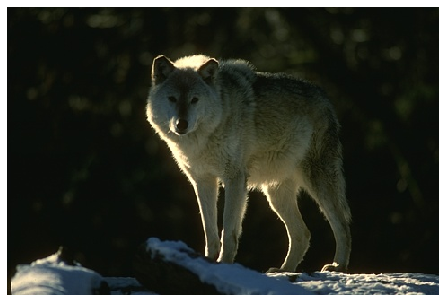

In [27]:
show_img_with_label(img)

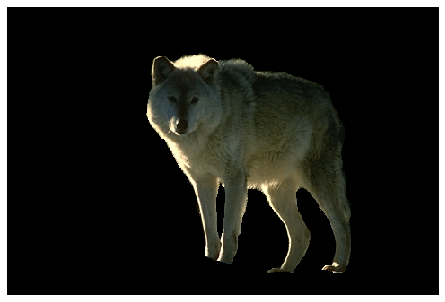

In [28]:
show_img_with_label(img,img_labels)

The following block contains the required functions for making an image graph.

In [29]:
# some constants
WIDTH = 4.0

# convolve image with gaussian filter
def smooth(src, sigma):
    mask = make_fgauss(sigma)
    mask = normalize(mask)
    tmp = convolve_even(src, mask)
    dst = convolve_even(tmp, mask)
    return dst


# gaussian filter
def make_fgauss(sigma):
    sigma = max(sigma, 0.01)
    length = int(math.ceil(sigma * WIDTH)) + 1
    mask = np.zeros(shape=length, dtype=float)
    for i in range(length):
        mask[i] = math.exp(-0.5 * math.pow(i / sigma, i / sigma))
    return mask


# normalize mask so it integrates to one
def normalize(mask):
    sum = 2 * np.sum(np.absolute(mask)) + abs(mask[0])
    return np.divide(mask, sum)


# convolve src with mask.  output is flipped!
def convolve_even(src, mask):
    output = np.zeros(shape=src.shape, dtype=float)
    height, width = src.shape
    length = len(mask)

    for y in range(height):
        for x in range(width):
            sum = float(mask[0] * src[y, x])
            for i in range(1, length):
                sum += mask[i] * (src[y, max(x - i, 0)] + src[y, min(x + i, width - 1)])
            output[y, x] = sum
    return output


# returns square of a number
def square(value):
    return value * value


# dissimilarity measure between pixels
def diff(red_band, green_band, blue_band, x1, y1, x2, y2):
    result = math.sqrt(
        square(red_band[y1, x1] - red_band[y2, x2]) + square(green_band[y1, x1] - green_band[y2, x2]) + square(
            blue_band[y1, x1] - blue_band[y2, x2]))
    return result

Making the graph of image.

In [30]:
def _get_image_graph(in_image, lables, sigma=0.5):
    height, width, band = in_image.shape
    smooth_red_band = smooth(in_image[:, :, 0], sigma)
    smooth_green_band = smooth(in_image[:, :, 1], sigma)
    smooth_blue_band = smooth(in_image[:, :, 2], sigma)

    # build graph
    uc_X = []
    uc_y = []
    row = []
    col = []
    data = []
    for y in range(height):
        for x in range(width):

            node_num = int(y * width + x)
            uc_X.append(in_image[y, x])
            uc_y.append(lables[y, x])

            if x < width - 1:
                neigh_num = int(y * width + (x + 1))
                weight = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y)

                row.append(node_num)
                col.append(neigh_num)
                data.append(weight)

                row.append(neigh_num)
                col.append(node_num)
                data.append(weight)

            if y < height - 1:
                neigh_num = int((y + 1) * width + x)
                weight = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x, y + 1)

                row.append(node_num)
                col.append(neigh_num)
                data.append(weight)

                row.append(neigh_num)
                col.append(node_num)
                data.append(weight)

            if (x < width - 1) and (y < height - 2):
                neigh_num = int((y + 1) * width + (x + 1))
                weight = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y + 1)
                row.append(node_num)
                col.append(neigh_num)
                data.append(weight)

                row.append(neigh_num)
                col.append(node_num)
                data.append(weight)

            if (x < width - 1) and (y > 0):
                neigh_num = int((y - 1) * width + (x + 1))
                weight = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y - 1)

                row.append(node_num)
                col.append(neigh_num)
                data.append(weight)

                row.append(neigh_num)
                col.append(node_num)
                data.append(weight)

    uc_adj = sparse.coo_matrix((data, (row, col)), shape=(len(uc_X), len(uc_X)))
    
    uc_graph = gsp.graphs.Graph(W=uc_adj)

    # TODO FIX THIS
    uc_opt_acc = 1.0

    uc_X = np.array(uc_X).T
    uc_y = np.array(uc_y)
    np.save('uc_X', uc_X)
    np.save('uc_y', uc_y)
    np.save('data', np.array(data))
    np.save('row', np.array(row))
    np.save('col', np.array(col))

    return uc_graph, uc_opt_acc, uc_y, uc_X


In [32]:
uc_graph, uc_opt_acc, uc_y, uc_X = _get_image_graph(img, img_labels)

/anaconda3/envs/DeepRL/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in ubyte_scalars


/anaconda3/envs/DeepRL/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


the accuracy by vanila logistic regression  0.7869379084332355
the coefficient by vanila logistic regression  [[ 0.18689641 -0.20160197  0.02106516]]
sampling ratio =  0.09955894068043601 ,reg =  1e-05 , unlabeled-node accuracy =  0.9867437728819167
labeled-node accuracy =  1.0
the aggregated accuracy =  0.9880635488112124
-----------------
the accuracy by vanila logistic regression  0.7854677107013556
the coefficient by vanila logistic regression  [[ 0.18248184 -0.19748634  0.02017809]]
sampling ratio =  0.10019365159552075 ,reg =  0.0001 , unlabeled-node accuracy =  0.9868999719285113
labeled-node accuracy =  0.998125404007757
the aggregated accuracy =  0.9880246889592684
-----------------
the accuracy by vanila logistic regression  0.7860635617644963
the coefficient by vanila logistic regression  [[ 0.18290589 -0.19997621  0.02409895]]
sampling ratio =  0.0997402866561745 ,reg =  0.001 , unlabeled-node accuracy =  0.9881079992230272
labeled-node accuracy =  0.9960389610389611
the ag

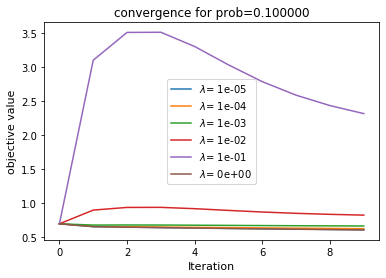

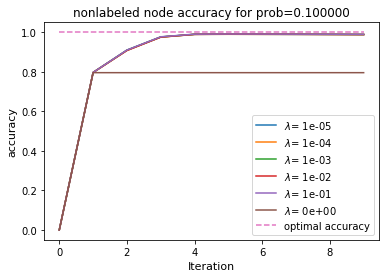

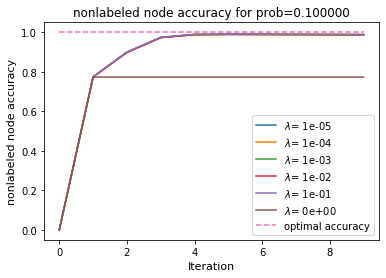

In [33]:
# prob = [0.01, 0.1, 0.5, 1.0]
prob = [0.1]
uc_non_acc, uc_acc = train(uc_graph, uc_X, uc_y, uc_opt_acc, 10, reg=reg, prob=prob, num_exps=1, M=None, is_plot=True, prefix="img",
                               is_saved=True, compare_with_lr=True)

So the best reg is 0.01 which its aggregated accuracy is 0.99.

In [48]:
def _get_lable(value):
    if value <= 0:
        return -1
    else:
        return 1

    
def _get_predicted_pixel_color(predicted_lable, true_lable):
    if predicted_lable != true_lable:
        # black
        return 0
    # white
    return 255

def _get_predicted_img():    
    w = np.load('w_0.010000_0.100000_0.npy')
    vanila_w = np.load('vanila_w_0.010000_0.100000.npy')

    height, width, band = img.shape

    predicted_img = np.zeros((height, width))
    predicted_vanila_img = np.zeros((height, width))

    lables = np.zeros((height, width))
    vanila_lables = np.zeros((height, width))

    i = 0
    for y in range(height):
        for x in range(width):
            lables[y, x] = _get_lable(np.dot(w[:, i], uc_X[:, i]))
            vanila_lables[y, x] = _get_lable(np.dot(vanila_w, uc_X[:, i]))

            predicted_img[y, x] = _get_predicted_pixel_color(lables[y, x], uc_y[i])
            predicted_vanila_img[y, x] = _get_predicted_pixel_color(vanila_lables[y, x], uc_y[i])

            i += 1
    return predicted_img, predicted_vanila_img, lables, vanila_lables

predicted_img, predicted_vanila_img, lables, vanila_lables = _get_predicted_img()

In the black and white image, white pixels have predicted correctly and black pixels have predicted wrongly by our method with reg=0.01.

missed lables by out method for reg: 0.01


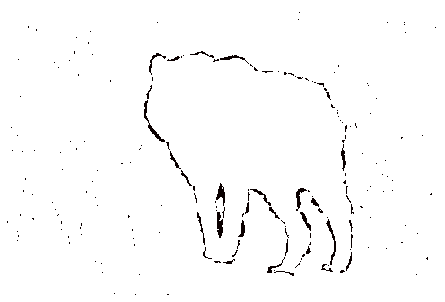

In [44]:
print('missed lables by out method for reg: 0.01')
show_img_with_label(predicted_img)

In the black and white image, white pixels have predicted correctly and black pixels have predicted wrongly by vanila logistic regression.

missed lables for vanila logistic regression


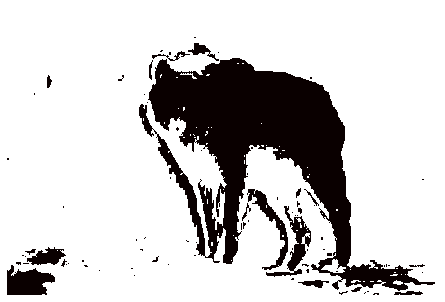

In [45]:
print('missed lables for vanila logistic regression')
show_img_with_label(predicted_vanila_img)

Image shows the foreground image that our method has predicted with reg = 0.01.

foreground image for reg: 0.01


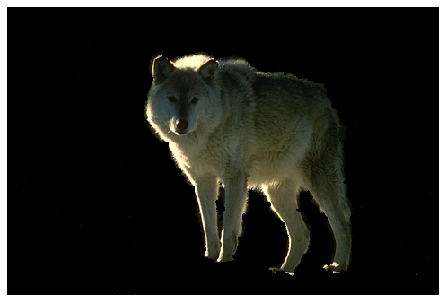

In [46]:
print('foreground image for reg: 0.01')
show_img_with_label(img, lables)

Image shows the foreground image that vanila logistic regression has predicted.

foreground image for vanila logistic Regression


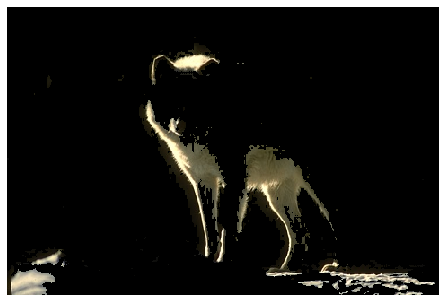

In [49]:
print('foreground image for vanila logistic Regression')
show_img_with_label(img, vanila_lables)

At the bellow image the white rectangular is selected as the sampling set.

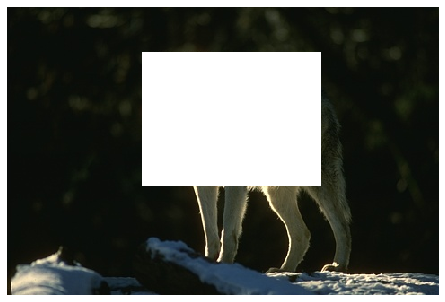

In [ ]:
# new_img = imageio.imread(img_file_name+ '.png')
# height, width, band = img.shape
# M_mtx = np.zeros((img.shape[0], img.shape[1]))
# M_mtx[50:200, 150:350] = 1
# 
# for y in range(height):
#     for x in range(width):
#         if M_mtx[y, x] == 1:
#             new_img[y, x] = (255, 255, 255)
#             
# show_img_with_label(new_img)
# 
# M = []
# for y in range(height):
#     for x in range(width):
#         M.append(1 if M_mtx[y, x] == 1 else 0)
# M = np.array(M)


/anaconda3/envs/DeepRL/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


the accuracy by vanila logistic regression  0.6719904663829898
the coefficient by vanila logistic regression  [[ 0.85489322 -0.9319281   0.29864161]]
sampling ratio =  0.11657955583189228 ,reg =  0.01 , unlabeled-node accuracy =  0.4277754561916701
labeled-node accuracy =  1.0
the aggregated accuracy =  0.4944851393449524
-----------------


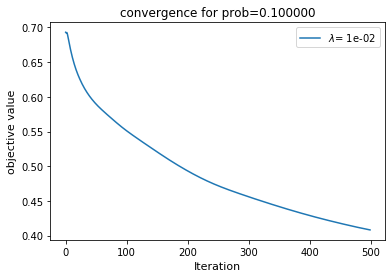

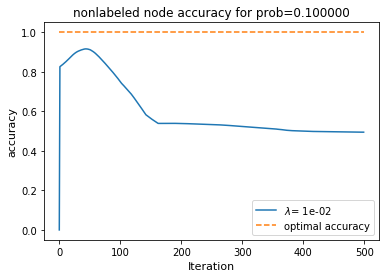

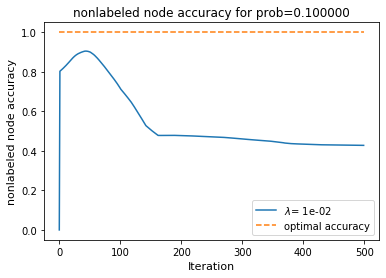

missed lables by our method for reg: 0.01
missed lables by vanila logistic for reg: 0.01


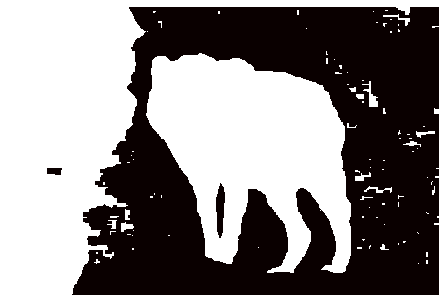

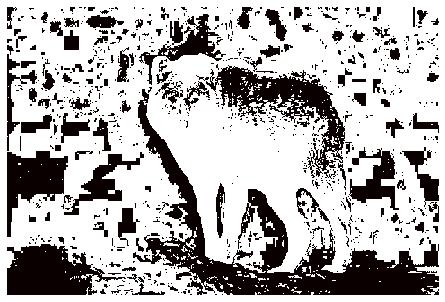

In [77]:
# uc_non_acc, uc_acc = train(uc_graph, uc_X, uc_y, uc_opt_acc, 500, reg=[0.01], prob=prob, num_exps=1, M=M, is_plot=True, prefix="img",
#                                is_saved=True, compare_with_lr=True)
# 
# predicted_img, predicted_vanila_img, lables, vanila_lables = _get_predicted_img()
# 
# print('missed lables by our method for reg: 0.01')
# show_img_with_label(predicted_img)
# 
# print('missed lables by vanila logistic for reg: 0.01')
# show_img_with_label(predicted_vanila_img)

Now we want to try separate sampling sets for foreground and background.

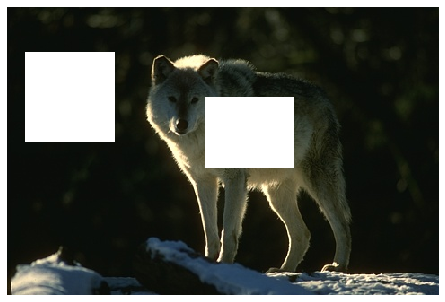

In [78]:
# new_img = imageio.imread(img_file_name+ '.png')
# height, width, band = img.shape
# M_mtx = np.zeros((img.shape[0], img.shape[1]))
# M_mtx[50:150, 20:120] = 1
# M_mtx[100:180, 220:320] = 1
# 
# for y in range(height):
#     for x in range(width):
#         if M_mtx[y, x] == 1:
#             new_img[y, x] = (255, 255, 255)
#             
# show_img_with_label(new_img)
# 
# M = []
# for y in range(height):
#     for x in range(width):
#         M.append(1 if M_mtx[y, x] == 1 else 0)
# M = np.array(M)

/anaconda3/envs/DeepRL/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


the accuracy by vanila logistic regression  0.6719904663829898
the coefficient by vanila logistic regression  [[ 0.85489322 -0.9319281   0.29864161]]
sampling ratio =  0.11657955583189228 ,reg =  0.01 , unlabeled-node accuracy =  0.4277754561916701
labeled-node accuracy =  1.0
the aggregated accuracy =  0.4944851393449524
-----------------


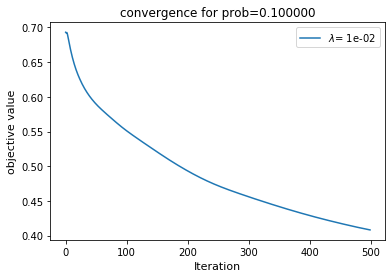

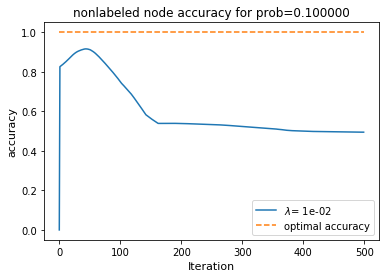

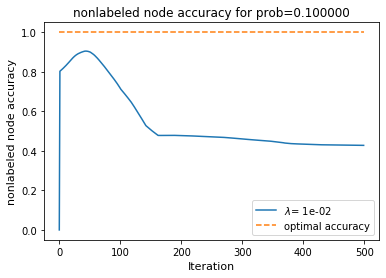

missed lables by our method for reg: 0.01
missed lables by vanila logistic for reg: 0.01


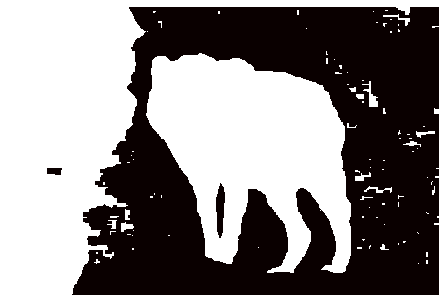

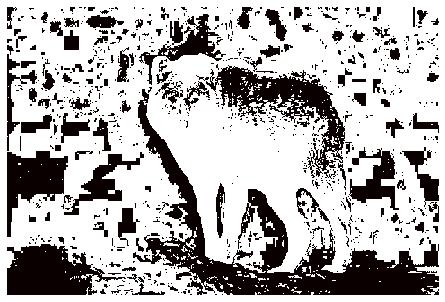

In [79]:
# uc_non_acc, uc_acc = train(uc_graph, uc_X, uc_y, uc_opt_acc, 500, reg=[0.01], prob=prob, num_exps=1, M=M, is_plot=True, prefix="img",
#                                is_saved=True, compare_with_lr=True)
# 
# predicted_img, predicted_vanila_img, lables, vanila_lables = _get_predicted_img()
# 
# print('missed lables by our method for reg: 0.01')
# show_img_with_label(predicted_img)
# 
# print('missed lables by vanila logistic for reg: 0.01')
# show_img_with_label(predicted_vanila_img)